# Figure 12: 

Illustration of the dominant contributions to the evolution of difference potential enstrophy during different stages of the cyclone growth (left). The right panel illustrates the underlying processes by means of fields that are closely related to the different contributions. Thick black contours denote the dynamical tropopause for the REF (dashed) and CRH (solid) simulations. Thin contours depict the surface pressure averaged between the two simulations.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
import xarray as xr
import colorlegend
from matplotlib import ticker

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading dataset 

In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2km', 'radiation':1, 'rh':0.8}, # No radiation
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2km', 'radiation':1, 'rh':0.8}, # Only cloud radiation
             }

In [4]:
# loading 2d datasets
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        #print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_1x1/'
        fname = path+"icon-atm2d*.nc"
        ds_var = xr.open_mfdataset(fname).sel(lat=slice(10,80))
        ds_list.append(ds_var)
        
    return ds_list
#----------------------------------
ds_list_atm2d = load_simulations()
#----------------------------------
# 3d datasets
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_1x1/datasets_pres_1x1/'
        fname = path+"icon-atm3d*.nc"
        ds_var = xr.open_mfdataset(fname).sel(lat=slice(10,80))
        ds_list.append(ds_var)
    return ds_list
#----------------------------------
ds_list_atm3d = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


In [5]:
# loading datasets

# simulations
res = ['02_03']
#-------------------------------------
def load_simulations():
    
    ds_list = []
    for sim in list(res): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/pverrorgrowth/'
   
        # model output 'pv_icon' used for calculation
        fname1 = path+'pverror_diag_1x1_'+sim+'.nc'
        ds_var1 = xr.open_dataset(fname1)
        ds_var1.attrs['res'] = sim
        ds_list.append(ds_var1)
                  
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for 02_03


In [6]:
# Function to load diagnostics from part 01 to depict dynamical tropopause
def load_simulations():
    
    ds_list = []
    
    for sim in list(simdict.keys()): 

        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_1x1/'
        # datasets
        fname = path+"pvdiag_calc_1x1.nc" 

        ds_var = xr.open_dataset(fname).sel(lat=slice(10,80))
        ds_list.append(ds_var)
        
        #del ds_var1,ds_var2

    return ds_list
#----------------------------------
ds_list_pvdiag = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


## 3- Plot

In [7]:
# common variables
lat  = ds_list[0].lat.values
lon  = ds_list[0].lon.values
time = ds_list[0].time
lev  = ds_list[0].lev

# PV error
p0 = ds_list_pvdiag[0].pv 
p1 = ds_list_pvdiag[1].pv
pv_error = p0 - p1        ## without CRH - with CRH

In [8]:
# surface_pressure averaged between the two simulation
p_sfc_mean = (ds_list_atm2d[0].pres_sfc + ds_list_atm2d[1].pres_sfc)/2

# precipitation error
prec0 = ds_list_atm2d[0]['tot_prec'].diff(dim='time', label='upper') # mm/hr
prec1 = ds_list_atm2d[1]['tot_prec'].diff(dim='time', label='upper')
prec_e = prec0 - prec1

# vertical velocity error at 500 hPa
omega_e = ds_list_atm3d[0].omega.sel(plev_2=50000) - ds_list_atm3d[1].omega.sel(plev_2=50000)

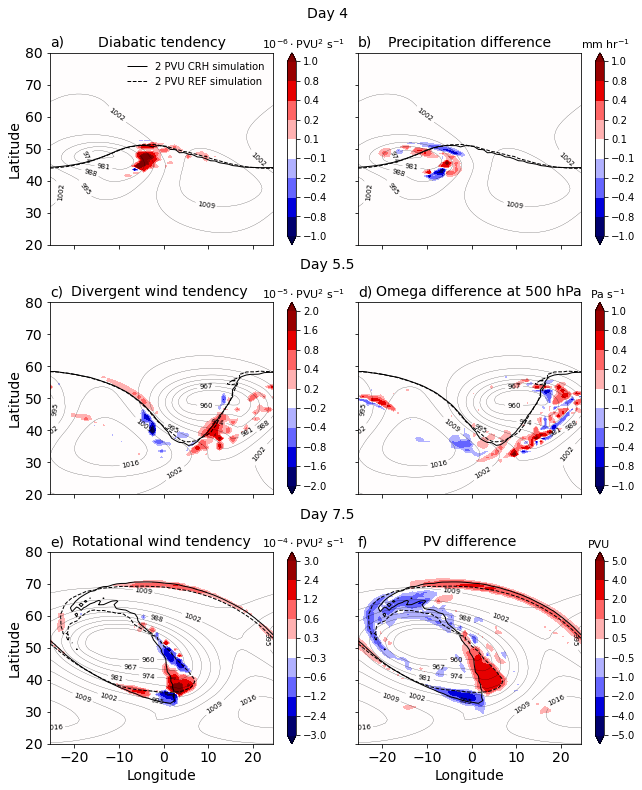

In [14]:
clevels = np.array([-1,-0.8,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.8,1])
cbar_num_format = "%.0e"
#---------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 12))

i = 0

title = ['Diabatic tendency','Precipitation difference','Divergent wind tendency ','    Omega difference at 500 hPa',
         'Rotational wind tendency', 'PV difference']

for ax in axes.flat:
    
    ax.tick_params(labelsize=14)
    ax.set_ylim([20, 80])
    ax.set_yticks(np.arange(20,90,10))
    ax.set_xticks(np.arange(-20,30,10))
    
    divider = make_axes_locatable(ax)
    cax_s = divider.append_axes('right', size='4%', pad=0.2)
    
    if i == 0:
        
        im = ax.contourf(lon-38,lat,(ds_list[0].ddtdia.sel(lev=326,time=20210105))*(1e6**2)*1e6
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)

        cbar = fig.colorbar(im,cax=cax_s,orientation='vertical',shrink=0.95)
        cbar.ax.tick_params(labelsize=10)
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210105)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs.collections[0].set_label('2 PVU CRH simulation')
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210105)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cs.collections[0].set_label('2 PVU REF simulation')
        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210105)/100,colors='k',linewidths=0.2,
                   levels=np.arange(960,1025,7))
        ax.clabel(cf, inline=1, fontsize=7,fmt='%1.f') 
        ax.legend(loc='upper right',frameon=False,fontsize=10)
        ax.set_title(title[0], fontsize=14)
        ax.set_xticklabels([]) 
        ax.set_ylabel('Latitude', fontsize=14)
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=14 )
        ax.text(0.95, 1.02, '$10^{-6} \cdot $PVU$^2$ s$^{-1}$', transform=ax.transAxes, 
            size=11 )
        
    if i == 1:
        
        im = ax.contourf(lon-38,lat,prec_e.sel(time=20210105)
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)
        cbar = fig.colorbar(im,cax=cax_s,orientation='vertical',shrink=0.95)
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210105)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210105)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210105)/100,colors='k',linewidths=0.2,
                   levels=np.arange(960,1025,7))
        ax.clabel(cf, inline=1, fontsize=7,fmt='%1.f')
        ax.set_title(title[1], fontsize=14)
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=14 )
        ax.text(1, 1.02, 'mm hr$^{-1}$', transform=ax.transAxes, 
            size=11 )
        
    if i == 2:
        
        im = ax.contourf(lon-38,lat,(ds_list[0].ddtdiv.sel(lev=326,time=20210106.5))*(1e6**2)*1e5
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels*2)
        
        cbar = fig.colorbar(im,cax=cax_s,orientation='vertical',shrink=0.95)
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210106.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210106.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210106.5)/100,colors='k',linewidths=0.2,
                   levels=np.arange(960,1025,7))
        ax.clabel(cf, inline=1, fontsize=7,fmt='%1.f')
        ax.set_title(title[2], fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xticklabels([])
        ax.text(0.0, 1.03, 'c)', transform=ax.transAxes, 
            size=14 )
        ax.text(0.95, 1.02, '$10^{-5} \cdot $PVU$^2$ s$^{-1}$', transform=ax.transAxes, 
            size=11 )
        
    if i == 3:
        
        im = ax.contourf(lon-38,lat,(omega_e.sel(time=20210106.5))
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)
        
        cbar = fig.colorbar(im,cax=cax_s,orientation='vertical',shrink=0.95)
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210106.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210106.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210106.5)/100,colors='k',linewidths=0.2,
                   levels=np.arange(960,1025,7))
        ax.clabel(cf, inline=1, fontsize=7,fmt='%1.f')
        ax.set_title(title[3], fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.text(0.0, 1.03, 'd)', transform=ax.transAxes, 
            size=14 )
        ax.text(1.04, 1.02, 'Pa s$^{-1}$', transform=ax.transAxes, 
            size=11 ) 
        
    if i == 4:
        
        im = ax.contourf(lon-38,lat,(ds_list[0].ddtrot.sel(lev=326,time=20210108.5))*(1e6**2)*1e4
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels*3)
        
        cbar = fig.colorbar(im,cax=cax_s,orientation='vertical',shrink=0.95)
        cbar.formatter.set_scientific(True)
        cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210108.5)/100,colors='k',linewidths=0.2,
                   levels=np.arange(960,1025,7))
        ax.clabel(cf, inline=1, fontsize=7,fmt='%1.f')
        ax.set_title(title[4], fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, 'e)', transform=ax.transAxes, 
            size=14 )
        ax.text(0.95, 1.02, '$10^{-4} \cdot $PVU$^2$ s$^{-1}$', transform=ax.transAxes, 
            size=11 )
        
    if i == 5:
        
        im = ax.contourf(lon-38,lat,(pv_error.sel(lev=326,time=20210108.5))*1e6,
                     levels=clevels*5, 
                     cmap=plt.get_cmap('seismic'),extend='both')
        
        cbar = fig.colorbar(im,cax=cax_s,orientation='vertical',shrink=0.95)
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210108.5)/100,colors='k',linewidths=0.2,
                   levels=np.arange(960,1025,7))
        ax.clabel(cf, inline=1, fontsize=7,fmt='%1.f')
        ax.set_title(title[5], fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, 'f)', transform=ax.transAxes, 
            size=14 )
        ax.text(1.03, 1.02, 'PVU', transform=ax.transAxes, 
            size=11 )
              
    i = i + 1      
        
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.25, hspace=0.3)  


plt.text(.45, 0.94, 'Day 4', transform=fig.transFigure, horizontalalignment='center',fontsize=14)
plt.text(.45, 0.65, 'Day 5.5', transform=fig.transFigure, horizontalalignment='center',fontsize=14)
plt.text(.45, 0.36, 'Day 7.5', transform=fig.transFigure, horizontalalignment='center',fontsize=14)


plt.savefig('figure12.pdf', bbox_inches = 'tight')
#plt.savefig('figure12.png', bbox_inches = 'tight',dpi=100)